In [1]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import ToPILImage
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import shutil
import random


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [01:11<00:00, 21.9MB/s]
100% 1.17G/1.17G [01:11<00:00, 17.5MB/s]


In [4]:
!unzip -q \*.zip && rm *.zip

In [5]:
data_set_train = []
data_set_test = []

train_Normal = '/content/chest_xray/train/NORMAL'
test_Normal = '/content/chest_xray/test/NORMAL'
train_pnemonia = '/content/chest_xray/train/PNEUMONIA'
test_pnemonia = '/content/chest_xray/test/PNEUMONIA'

contents1 = os.listdir(train_Normal)
contents2 = os.listdir(test_Normal)
contents3 = os.listdir(train_pnemonia)
contents4 = os.listdir(test_pnemonia)

for item in contents1:
  data_set_train.append((Image.open(os.path.join(train_Normal, item)), 0))

for item in contents2:
  data_set_test.append((Image.open(os.path.join(test_Normal, item)), 0))

for item in contents3:
  data_set_train.append((Image.open(os.path.join(train_pnemonia, item)), 1))

for item in contents4:
  data_set_test.append((Image.open(os.path.join(test_pnemonia, item)), 1))

random.shuffle(data_set_train)
random.shuffle(data_set_test)

print(len(data_set_train), len(data_set_test))



5232 624


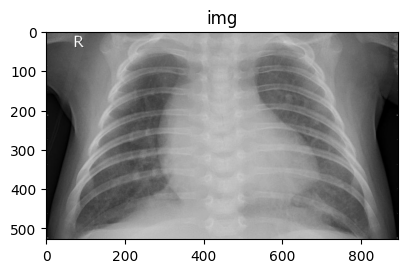

In [6]:
# Assuming data_set_train is a list of (image, label) tuples
train_img, train_label = random.choice(data_set_train)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
ax.imshow(train_img, cmap='gray')
ax.set_title('img')
plt.show()

In [7]:
class brain_tumour(Dataset):
    def __init__(self, mode, data_set_train, data_set_test):

        self.mode = mode

        if self.mode == 'train':
            self.images = [item[0] for item in data_set_train]
            self.labels = [item[1] for item in data_set_train]
        elif self.mode == 'test':
            self.images = [item[0] for item in data_set_test]
            self.labels = [item[1] for item in data_set_test]
        else:
            raise ValueError('Invalid mode')

        self.transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    def __len__(self):

        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.convert('RGB')
        image = self.transform(image)
        if self.mode:
            label = self.labels[idx]
            return image.to('cuda'), label

In [8]:
batch_size = 50
learning_rate = 0.001
epochs = 15

In [9]:
train_set = brain_tumour('train', data_set_train, data_set_test)
test_set = brain_tumour('test', data_set_train, data_set_test)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)



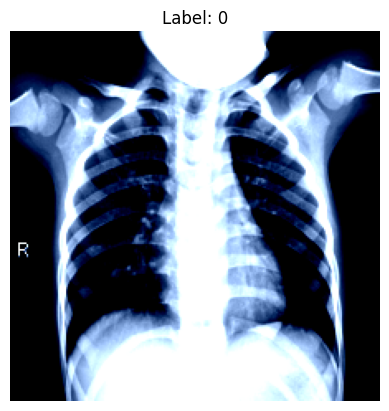

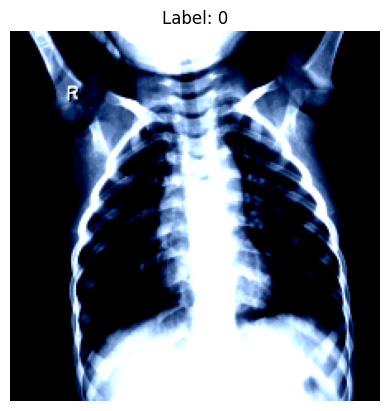

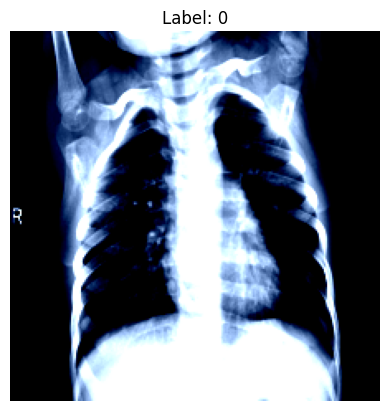

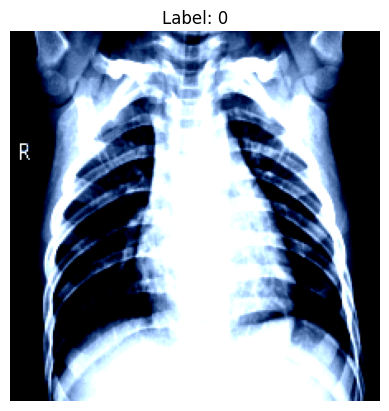

In [10]:
# Iterate over the train_dataloader
counter = 0
for idx, (images, labels) in enumerate(train_dataloader):
    # Access the first batch
    # Get the first image and label from the batch
    image = images[idx]
    label = labels[idx]


    # Convert the image tensor to a NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Display the image using Matplotlib
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label.item()}')
    plt.axis('off')
    plt.show()
    if counter == 3:
      break
    else:
      counter = counter +1

In [11]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers of your CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(50176, 256)  # Adjust input size based on your image dimensions after pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        # Implement the forward pass
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        flatten = nn.Flatten()
        x = flatten(x)  # Flatten the tensor for fully connected layers
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x


In [12]:
#optimizer
model = Net().to('cuda')
criterion = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [13]:
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = []
    total_train = 0
    train_correct = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda').unsqueeze(1).float()

        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        pred_outputs = (outputs > 0.5).float()
        train_correct += (pred_outputs == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = np.mean(train_loss)
    train_acc = train_correct / total_train

    # Validation phase
    model.eval()
    test_loss = []
    total_test = 0
    test_correct = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda').unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())
            pred_outputs = (outputs > 0.5).float()
            test_correct += (pred_outputs == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = np.mean(test_loss)
    test_acc = test_correct / total_test

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/15], Train Loss: 0.6137, Train Acc: 0.7408, Test Loss: 0.6841, Test Acc: 0.6250
Epoch [2/15], Train Loss: 0.5121, Train Acc: 0.7485, Test Loss: 0.4937, Test Acc: 0.7099
Epoch [3/15], Train Loss: 0.2634, Train Acc: 0.8974, Test Loss: 0.4415, Test Acc: 0.8782
Epoch [4/15], Train Loss: 0.1967, Train Acc: 0.9287, Test Loss: 0.4409, Test Acc: 0.8894
Epoch [5/15], Train Loss: 0.1624, Train Acc: 0.9373, Test Loss: 0.7059, Test Acc: 0.8365
Epoch [6/15], Train Loss: 0.1568, Train Acc: 0.9448, Test Loss: 0.6155, Test Acc: 0.8365
Epoch [7/15], Train Loss: 0.1460, Train Acc: 0.9415, Test Loss: 0.5574, Test Acc: 0.8654
Epoch [8/15], Train Loss: 0.1362, Train Acc: 0.9499, Test Loss: 0.7778, Test Acc: 0.8237
Epoch [9/15], Train Loss: 0.1314, Train Acc: 0.9555, Test Loss: 0.6326, Test Acc: 0.8606
Epoch [10/15], Train Loss: 0.1303, Train Acc: 0.9515, Test Loss: 0.6863, Test Acc: 0.8189
Epoch [11/15], Train Loss: 0.1226, Train Acc: 0.9534, Test Loss: 0.6749, Test Acc: 0.8526
Epoch [12/15], Trai

KeyboardInterrupt: 

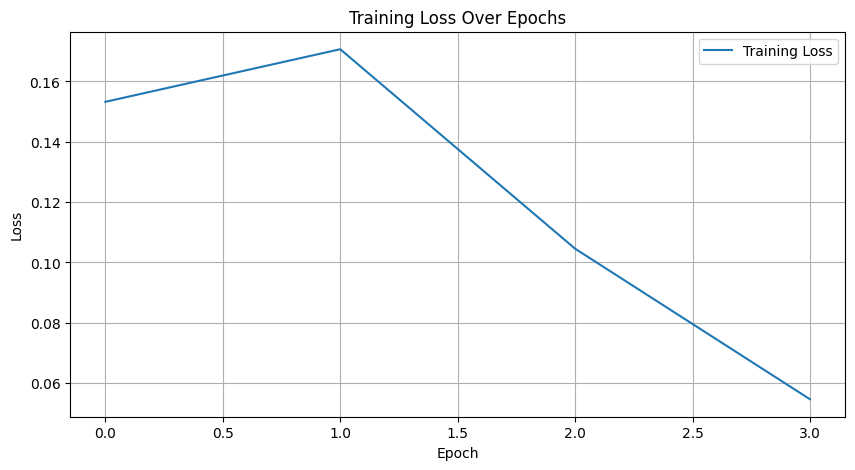

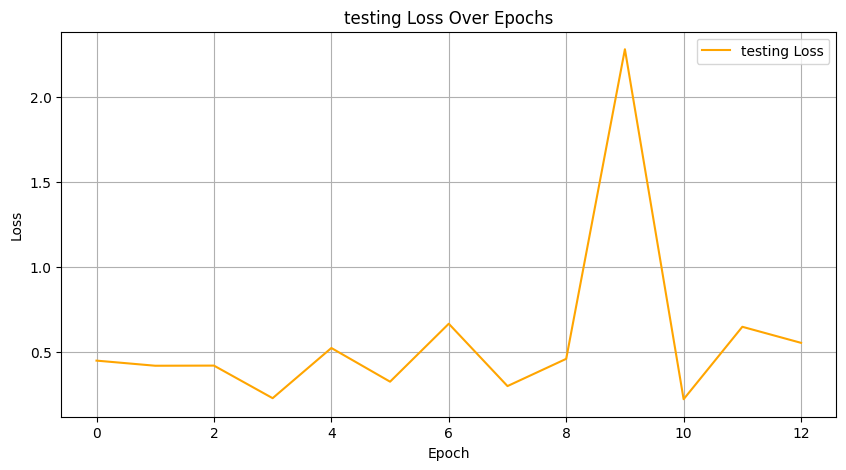

In [17]:
epochs = range(len(train_loss))
epochs2 = range(len(test_loss))

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting testing loss
plt.figure(figsize=(10, 5))
plt.plot(epochs2, test_loss, label='testing Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()